# The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in camera_calibrator.py.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

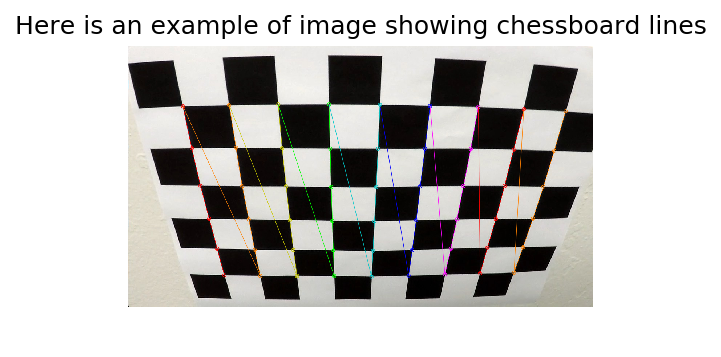

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

chessboard_images = glob.glob('./output_images/11_chessboard.png')
fig = plt.figure(figsize=(4, 8), dpi=150)
plt.imshow(mpimg.imread(chessboard_images[0]))
plt.axis('off')
plt.title('Here is an example of image showing chessboard lines')

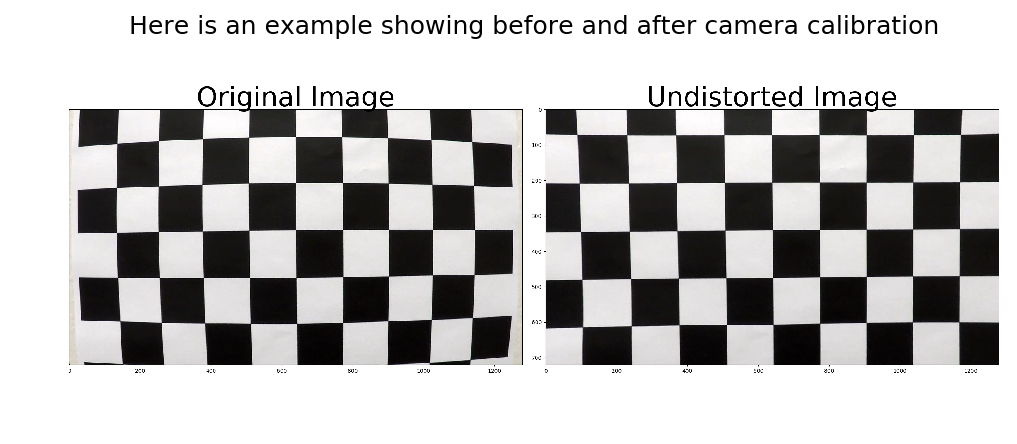

In [2]:
compare_images = glob.glob('./output_images/*_compare.png')

fig = plt.figure(figsize=(8, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Here is an example showing before and after camera calibration')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I apply the distortion correction to one of the test images like this one:

~~~
        img = mpimg.imread(fname)  # to keep things consistent with plotting color space.
        dst = cv2.undistort(img, mtx, dist, None, mtx)
~~~
This code uses camera matrix that was generated earlier. 

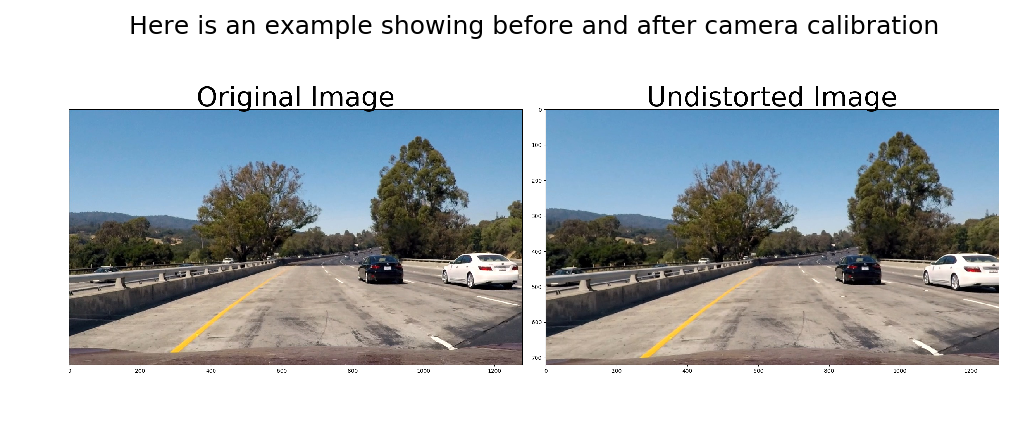

In [3]:
compare_images = glob.glob('./output_images/22_compare.png')
fig = plt.figure(figsize=(8, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Here is an example showing before and after camera calibration')


#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines 108 through 113 in `binary_thresholder.py`).  Here's an example of my output for this step.  


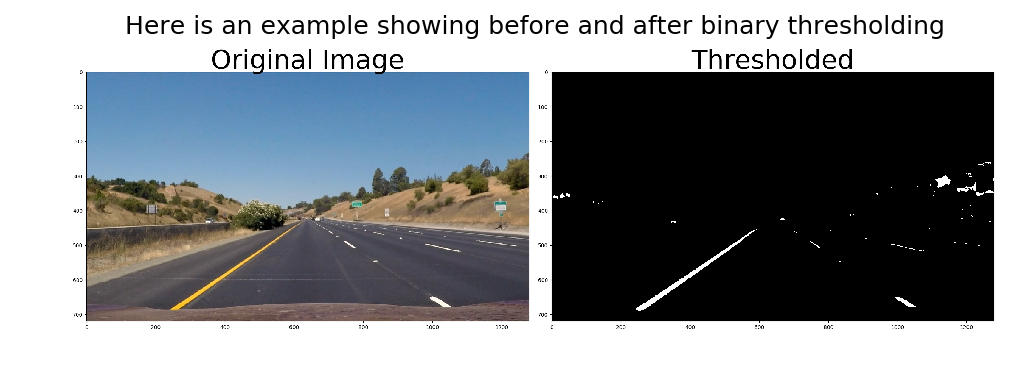

In [4]:
compare_images = glob.glob('./output_images/*_thresholded.png')
fig = plt.figure(figsize=(8, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Here is an example showing before and after binary thresholding')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `get_perspective_transform()`, which appears in lines 7 through 41 in the file `perspective_transformer.py`.  The `get_perspective_transform()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```python
src = np.array([[585. / 1280. * img_size[1], 455. / 720. * img_size[0]],
                        [705. / 1280. * img_size[1], 455. / 720. * img_size[0]],
                        [1130. / 1280. * img_size[1], 720. / 720. * img_size[0]],
                        [190. / 1280. * img_size[1], 720. / 720. * img_size[0]]], np.float32)
dst = np.float32(
        dst = np.array([[300. / 1280. * img_size[1], 100. / 720. * img_size[0]],
                        [1000. / 1280. * img_size[1], 100. / 720. * img_size[0]],
                        [1000. / 1280. * img_size[1], 720. / 720. * img_size[0]],
                        [300. / 1280. * img_size[1], 720. / 720. * img_size[0]]], np.float32)
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 455      | 300, 100        | 
| 705, 455      | 1000, 100      |
| 1130, 720     | 1000, 720      |
| 190, 720     | 300, 720        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.



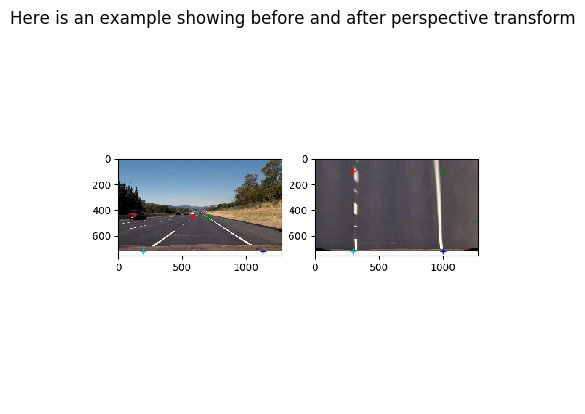

In [5]:
compare_images = glob.glob('./output_images/perspective_transform.png')
fig = plt.figure(figsize=(6, 16), dpi=100)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Here is an example showing before and after perspective transform')

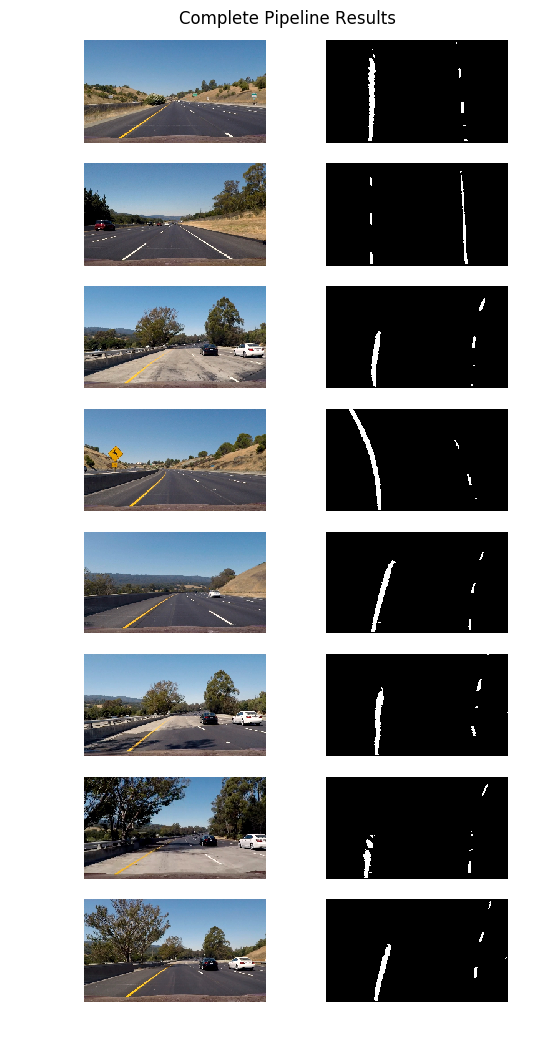

In [6]:
compare_images = glob.glob('./output_images/test_images_pipeline.png')
fig = plt.figure(figsize=(6, 16), dpi=100)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Complete Pipeline Results')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

For Line Finding Method, I used *Peaks in a Histogram* method.

After applying calibration, thresholding, and a perspective transform to a road image, I used the binary image where the lane lines stand out clearly. For identifying lines, I used peaks in histogram method. 

With this histogram I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame. 


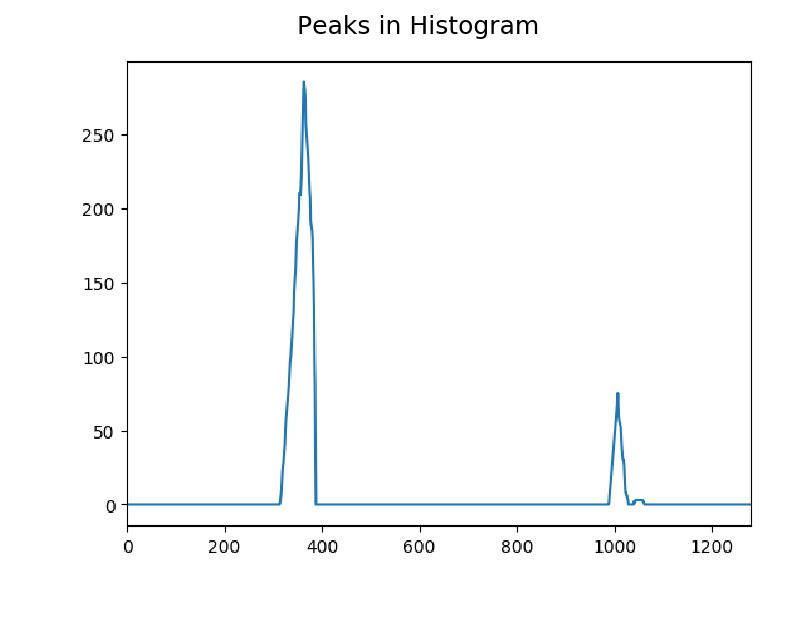

In [7]:
compare_images = glob.glob('./output_images/polyfit_result_histogram.png')
fig = plt.figure(figsize=(6, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Peaks in Histogram')

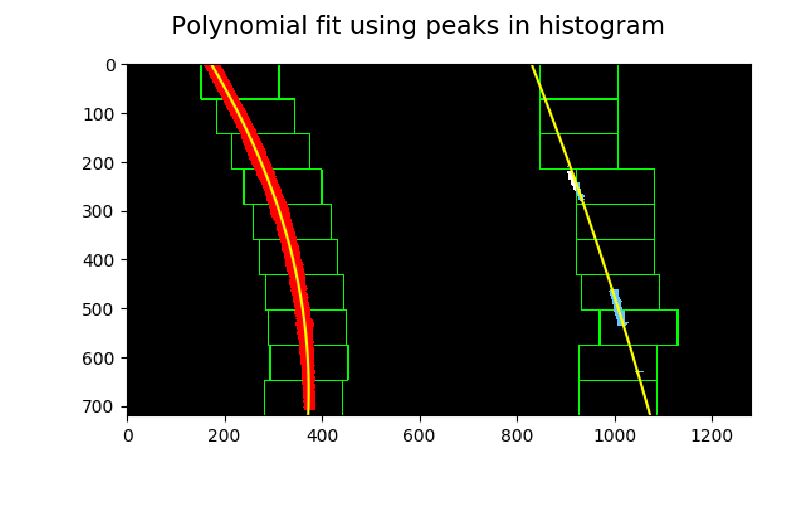

In [8]:
compare_images = glob.glob('./output_images/polyfit_result.png')
fig = plt.figure(figsize=(6, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Polynomial fit using peaks in histogram')

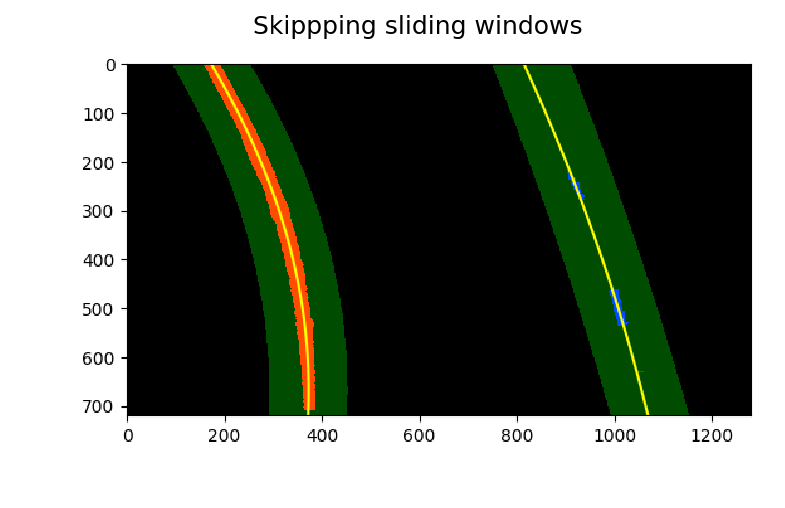

In [9]:
compare_images = glob.glob('./output_images/polyfit_result_using_prev.png')
fig = plt.figure(figsize=(6, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Skippping sliding windows')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines 116 through 158 in my code in `sliding_window_polyfit.py`


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines 7 through 48 in my code in `lane_drawer.py` in the function `draw_lane()`.  Here is an example of my result on a test image:

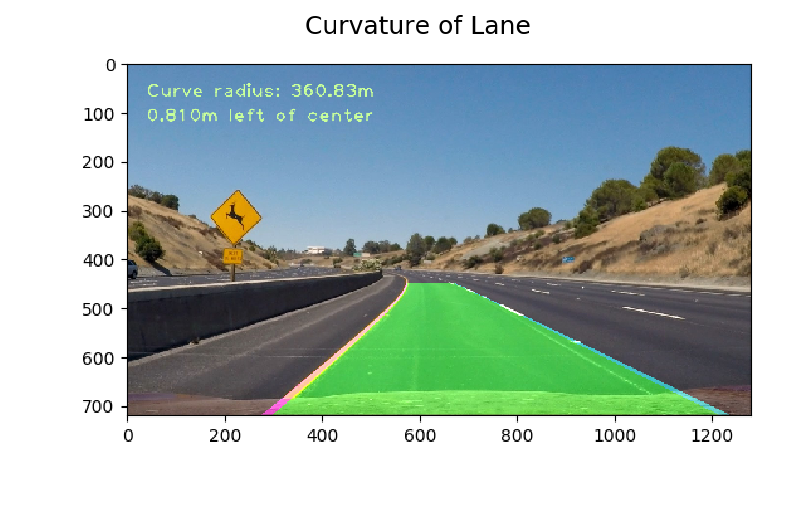

In [10]:
compare_images = glob.glob('./output_images/polyfit_result_with_lanes.png')
fig = plt.figure(figsize=(6, 16), dpi=150)
plt.imshow(mpimg.imread(compare_images[0]))
plt.axis('off')
plt.title('Curvature of Lane')

## Video with lanes identified

In [11]:
from IPython.display import HTML

video_output = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Discussion

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

This assignment required re-reading some of the concepts from the previous chapter, experimenting with few different colorspaces and techniques for thresholding and finally combining to make it work in the video.

One of the big challenges I am currently having is to make this lane line draw properly for challenge videos. The pipeline is tested for fairly decent road conditions. In Calgary, we see all sorts or road conditions from like snow cover, black ice, no yellow lines and steeper sections. TYhese areas I think will certainly be a challenge for current implementation. 

Here are few things that I would like to try:

* Using higher order polynomial for curvier roads
* Some other colorspaces and tweaking thresholding parameters 
* Making line class more robust to sudden changes in point data
* Code optimizations and cleranup
